# Trees

First, we have to prepare the data and the libraries :

In [1]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))]
data$Intensity<-as.numeric(as.factor(data$Intensity)) 
data<-data[ ,( which(apply(data, 2, var) != 0))]

set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

data.train.x <- data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
data.train.x.matrix <- as.matrix(data.train.x)
data.train.y <- data.train$VALENCE.PLEASANTNESS

data.test.x <- data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data.test.x.matrix <- as.matrix(data.test.x)
data.test.y <- data.test$VALENCE.PLEASANTNESS

In [3]:
library(tree)
library(randomForest)
library(xgboost)

### Simple tree regression

As a baseline model and to see the result of the simplest model, we perform a simple tree regression on the data set, taking into account all the predictors whose variance is not equal to zero :

In [4]:
tree.data.train <- tree(VALENCE.PLEASANTNESS ~ ., data = data.train)
summary(tree.data.train)

pred.test <- predict(tree.data.train, newdata = data.test.x)
MSE.test <- mean((pred.test - data.test.y)^2)
RMSE.test <- sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))

pred.train <- predict(tree.data.train,data.train.x)
MSE.train <- mean((pred.train - data.train.y)^2)
RMSE.train <- sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))


Regression tree:
tree(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)
Variables actually used in tree construction:
 [1] "Eig04_EA.ri."           "Mor21v"                 "GNar"                  
 [4] "Mor10e"                 "P_VSA_MR_7"             "B04.C.S."              
 [7] "P_VSA_LogP_2"           "R6s."                   "HATS6p"                
[10] "GATS4m"                 "Mor10s"                 "Mor07p"                
[13] "HATS7s"                 "JGI2"                   "Mor03m"                
[16] "MATS4m"                 "GATS5e"                 "Mor27u"                
[19] "G3u"                    "complexity.from.pubmed" "DLS_cons"              
[22] "RTs"                    "RDF045s"                "G3e"                   
Number of terminal nodes:  25 
Residual mean deviance:  220.8 = 72640 / 329 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-41.6200  -9.1760   0.0625   0.0000   8.3780  50.9100 

[1] "test MSE :756.039616713886"
[1] "test RMSE :27.4961745832741"
[1] "train MSE :205.210269500844"
[1] "train RMSE :14.325162110805"


The test RMSE that we found is quite high, so we have to try another method to decrease this test RMSE. We tried to do cross validation on pruned trees but the test RMSE was not better than the RMSE of simple regression trees.

### Random Forest

We first performed a simple bagging method and obtained a test error of 22.745 which is better than with simple tree regression but we now try to improve this result with a random forest approach.

We chose to compare the results of random forest for m between 50 and 120 because the typical choice of m is sqrt(nb of parameters) :

We use cross-validation to determine m. (Please be aware this can takes 1-2hours to run)

[1] "m that give the min test RMSE is :108"
[1] "test RMSE min :22.6843980558782"


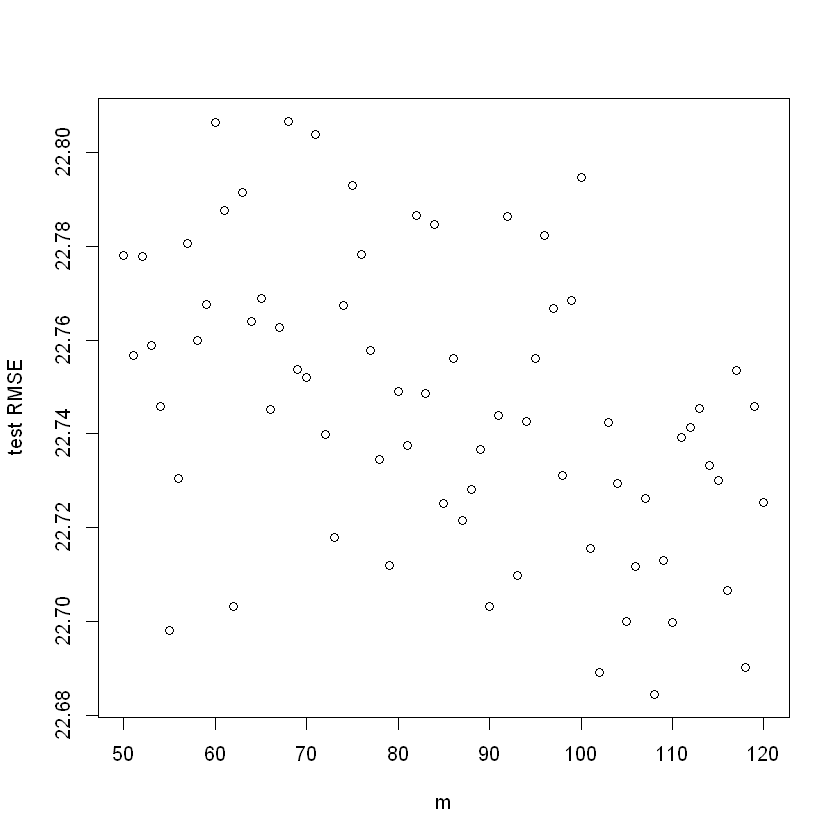

In [15]:
set.seed(1)
library(tidymodels)
validation_data <- vfold_cv(data, v = 5) # create the 5 folds
cv_random_forest <- function(fold,m) {
    data.train<-analysis(fold)
    data.test<-assessment(fold)
    rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) #ntree = 500 by default
    pred <- predict(rf, data.test[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))])
    MSE = mean((pred - data.test$VALENCE.PLEASANTNESS)^2)
    sqrt(MSE)
}
c<-sapply(50:120, function(m) mean(sapply(validation_data$splits, cv_random_forest, m)))

plot(50:120,c,xlab='m',ylab='test RMSE')
n <- which.min(c) + 49 #Change the 49 if we change the intervall of m 50:120
print(paste0('m that give the min test RMSE is :', n)) 
print(paste0('test RMSE min :', c[which.min(c)]))


c is a vector of the mean RMSE on the folds for each m value 

With cross-validation we found that the best m is ... and to compare this result with the other method we can now fit a random forest to the training set and compute the test RMSE.

In [16]:
set.seed(1)
rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = n) #Change the 49 if we change the intervall of m 50:120
pred.train <- predict(rf, data.train.x)
pred.test<-predict(rf,data.test.x)
RMSE.train <- sqrt(mean((pred.train-data.train.y)^2))
RMSE.test <- sqrt(mean((pred.test-data.test.y)^2))
print(paste0('train RMSE with best m :', RMSE.train))
print(paste0('test RMSE with best m: ', RMSE.test))

[1] "train RMSE with best m :12.0318190646339"
[1] "test RMSE with best m: 23.0420669278474"


We fit the best random forest model on all the training data to have a better prediction on the test data in order to do a kaggle submission:

In [17]:
set.seed(1)
rf.best <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data, mtry = n)

In [18]:
data_training <- read.csv(file.path("..", "data", "training_data.csv"))
data_training$Intensity<-as.numeric(as.factor(data_training$Intensity))
data_training <- data_training[,-which(names(data_training) %in% c("VALENCE.PLEASANTNESS"))]
data_training <-data_training[,-which(names(data_training) %in% c("SWEETORSOUR"))]

data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]
data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,( which(apply(data_training, 2, var) != 0))] #remove the same predictors   

pred_test <- predict(rf.best,data_test)
pred_test
data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
#data_sub
write.csv(data_sub,file="Sub7.csv", row.names = FALSE)

1        2        3        4        5        6        7        8 
35.01858 51.78754 41.37791 50.67509 36.56865 56.59457 39.84742 46.92769 
       9       10       11       12       13       14       15       16 
45.33483 50.68130 28.48000 48.99005 42.17888 42.47992 48.74193 50.93881 
      17       18       19       20       21       22       23       24 
38.14918 40.75523 35.40718 52.86404 50.72006 45.79754 45.84293 54.39694 
      25       26       27       28       29       30       31       32 
42.46332 50.85240 52.04631 47.60570 64.69703 30.09484 54.23890 36.80760 
      33       34       35       36       37       38       39       40 
27.27460 45.31445 49.91849 41.74168 53.00641 47.83416 45.89188 39.86763 
      41       42       43       44       45       46       47       48 
44.19869 49.31405 47.29882 48.82685 51.16681 41.48010 41.53969 47.03084 
      49       50       51       52       53       54       55       56 
33.92591 36.96512 37.90812 45.60740 59.96428 43.34589 41.00952 36.75402 
      57       58       59       60       61       62       63       64 
46.88939 44.77335 47.96702 47.03897 37.84870 41.48243 50.65311 33.48401 
      65       66       67       68 
53.54968 48.88027 45.20893 49.07462

The test error is better than the bagging method. Let's try boosting to see if we can improve the test RMSE :

### Boosting

First, we selected the lambda (shrinkage parameter) that gives the lowest test error : 

[1] "test RMSE : 22.4260386806041"
[1] "lambda min test :0.00316227766016838"
[1] "train RMSE with the lambda min test : 14.3740302778053"
[1] "train min RMSE : 3.30660293636581"
[1] "lambda min train : 0.398107170553497"


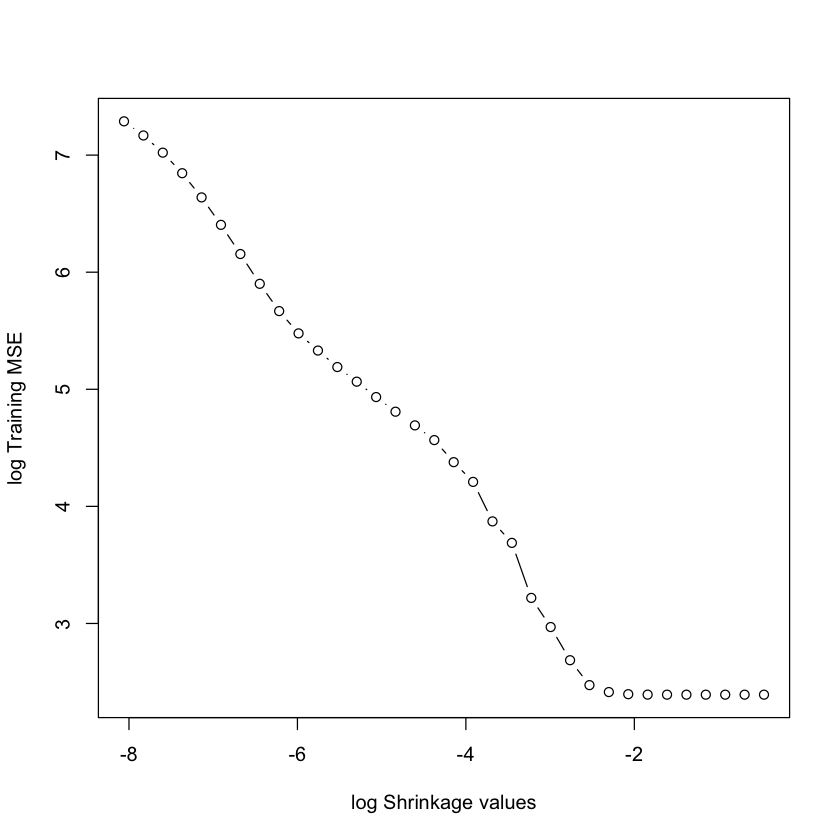

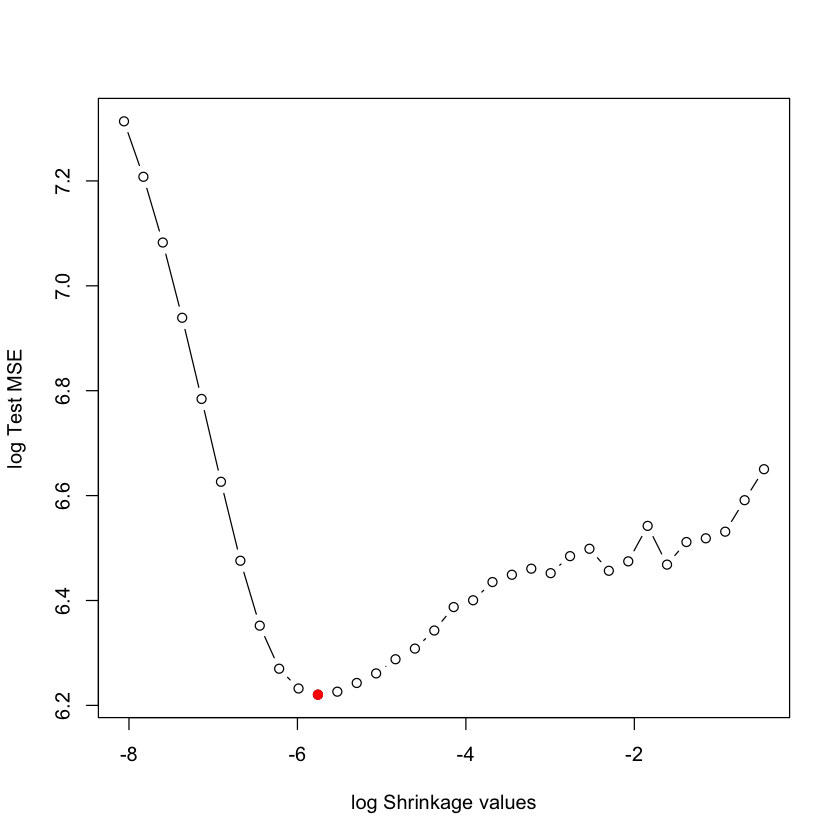

In [23]:
set.seed(3)
pows <- seq(-3.5, -0.2, by = 0.1)
lambdas <- 10^pows
train.err <- rep(NA, length(lambdas))
test.err <- rep(NA, length(lambdas))
for (i in 1:length(lambdas)) {
  boost <- xgboost(data.train.x.matrix,
                           label=data.train.y,
                           eta=lambdas[i],
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=1000,
                           verbose = 0)
  pred.train <- predict(boost, data.train.x.matrix)
  pred.test <- predict(boost, data.test.x.matrix)
  train.err[i] <- mean((pred.train - data.train.y)^2)
  test.err[i] <- mean((pred.test - data.test.y)^2)
}

MSEmin.test <- min(test.err)
lambdamin.test <- lambdas[which.min(test.err)]
MSE.train <- train.err[which.min(test.err)]
MSEmin.train <- min(train.err)
lambdamin.train <- lambdas[which.min(train.err)]

print(paste0('test RMSE : ', sqrt(MSEmin.test)))
print(paste0('lambda min test :', lambdamin.test))
print(paste0('train RMSE with the lambda min test : ', sqrt(MSE.train)))
print(paste0('train min RMSE : ', sqrt(MSEmin.train)))
print(paste0('lambda min train : ', lambdamin.train))

plot(log(lambdas), log(train.err), type="b", xlab="log Shrinkage values", ylab="log Training MSE")
plot(log(lambdas), log(test.err), type="b", xlab="log Shrinkage values", ylab="log Test MSE")
points(log(lambdas[which.min(test.err)]), log(min(test.err)), col="red", pch=19)

We can see that the test RMSE is better, so we can try to still improve this method.

To improve the method we can do cross validation to select the optimal number of rounds : 

##### xgb.cv 6-folds
    iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
       1        48.98617      0.3524666       48.96600      1.790120
       2        48.85708      0.3523474       48.84425      1.789703
       3        48.72813      0.3521329       48.72223      1.789485
       4        48.59996      0.3520204       48.60144      1.789047
       5        48.47193      0.3518089       48.48039      1.788818
---                                                                 
    1496        11.89704      0.3147232       23.24164      1.151748
    1497        11.89468      0.3150516       23.24187      1.151921
    1498        11.89240      0.3153672       23.24270      1.152625
    1499        11.88996      0.3155262       23.24261      1.152408
    1500        11.88765      0.3155635       23.24293      1.152211
[1] "the best iteration is : 1012"
[1] "the best CV RMSE is : 23.0130048333333"


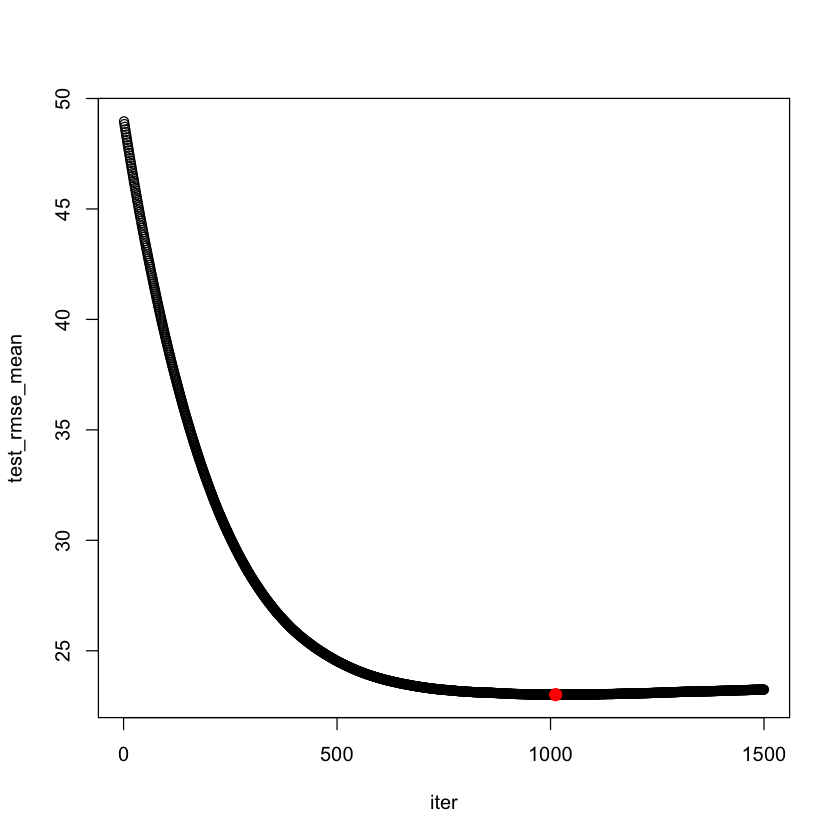

In [24]:
set.seed(1)
boost.cv <- xgb.cv(params = list(eta=lambdamin.test, objective="reg:squarederror",max.depth=3),
                     data = data.train.x.matrix,
                     label = data.train.y,
                     nrounds = 1500,
                     nfold = 6,
                     verbose = 0)
print(boost.cv)

df <- data.frame(X = boost.cv$evaluation_log[,1], Y=boost.cv$evaluation_log[,4])
plot(df)
df_m <- as.matrix(df)
min <- which.min(df_m[,2])
print(paste0('the best iteration is : ',df_m[,1][min]))
print(paste0('the best CV RMSE is : ',df_m[,2][min]))
points(df_m[,1][min],df_m[,2][min], col = "red", cex = 2, pch = 20)

We find that the optimal number of round is 1012 and now that we have the best shrinkage parameter and the best number of rounds we can verify by cross-valdiation the value of the optimal maximum depth.

In [7]:
#trying with cross-validation to have better results
set.seed(3)
library(tidymodels)

validation_data <- vfold_cv(data, v = 5) # create the 5 folds

cv_boost <- function(fold,m) {
    data.train<-analysis(fold)
    datax<-data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
    datax<-as.matrix(datax)
    datay<-data.train$VALENCE.PLEASANTNESS
    data.test<-assessment(fold)
    datax.test<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
    datax.test<-as.matrix(datax.test)
    datay.test<-data.test$VALENCE.PLEASANTNESS
    boost <- xgboost(datax,
                       label=datay,
                       eta=lambdamin.test,
                       objective="reg:squarederror",
                       max.depth=m,
                       nrounds=df_m[,1][min]),
                       verbose = 0)
    pred.train <- predict(boost, datax)
    pred.test <- predict(boost, datax.test)

    #train.err<<-c(train.err, mean((pred.train - datay)^2))
    test.err<-sqrt(mean((pred.test - datay.test)^2))
    return(test.err)
}
#trying with apply to have better results
m=1:10
c<-sapply(1:length(m), function(m) mean(sapply(validation_data$splits, cv_boost, m)))

In [9]:
test.err<-c
RMSE.min.test <- min(test.err)
m.min.test <- which.min(test.err)
#RMSE.train <- train.err[which.min(test.err)]    easier without train
                        
print(paste0('test RMSE : ', RMSE.min.test))
print(paste0('m min test :', m.min.test))
#print(paste0('train RMSE with the m min test : ', RMSE.train))     


[1] "test RMSE : 22.0452744286615"
[1] "m min test :3"


Now that all paramters are tuned together and the test RMSE is satisfying so, we do a kaggle submission with this model (best.boost) and train it on the whole data set to have better accuracy:

In [28]:
set.seed(1)
data.x <- data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))]
data.x.matrix <- as.matrix(data.x)
data.y <- data$VALENCE.PLEASANTNESS

best.boost <- xgboost(data.x.matrix,
                           label=data.y,
                           eta=lambdamin.test,
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=df_m[,1][min],
                           verbose = 0)

In [29]:
data_training <- read.csv(file.path("..", "data", "training_data.csv"))
data_training$Intensity<-as.numeric(as.factor(data_training$Intensity))
data_training <- data_training[,-which(names(data_training) %in% c("VALENCE.PLEASANTNESS"))]
data_training <-data_training[,-which(names(data_training) %in% c("SWEETORSOUR"))]

data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]
data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,( which(apply(data_training, 2, var) != 0))] #remove the same predictors   
data_test_matrix <- as.matrix(data_test)


pred_test <- predict(best.boost,data_test_matrix)
pred_test
data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
#data_sub.2
write.csv(data_sub,file="Sub5.csv", row.names = FALSE)

[1] 33.88985 42.20794 43.01880 50.44516 40.31726 52.21507 34.40659 46.25909
 [9] 39.97702 50.35918 30.94229 45.73165 43.82508 43.67200 45.24464 45.47273
[17] 37.82880 34.03488 38.05851 50.01377 45.38098 36.51365 35.32598 45.89420
[25] 36.75158 38.24572 51.76247 47.73576 59.67324 24.92072 42.37881 41.97732
[33] 26.72426 37.62655 46.71475 34.59078 49.95180 50.37186 42.74649 40.14237
[41] 43.12096 47.45569 50.53518 47.71426 40.03295 40.63630 32.95418 31.83267
[49] 32.18852 35.32510 32.99614 45.45370 55.21926 39.39662 40.58268 40.26297
[57] 42.19947 44.65061 47.67961 47.19922 40.65837 31.56621 40.41408 38.04266
[65] 52.47889 46.61135 40.18716 45.02673